In [23]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from transformers import BertTokenizer, TFBertModel
from tensorflow.python import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.layers import GlobalAveragePooling1D, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string
import re
string.punctuation
from keras.models import Sequential
from tensorflow.keras import models, layers, metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import spacy

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
df_model = pd.read_pickle("/content/drive/My Drive/Capstone/data/df.pkl")

In [27]:
df_balanced = df_model.rename(columns={"Post Text": "text"})

In [28]:
X = df_balanced['text']
y=np.unique(df_balanced['label'], return_inverse=True)[1]

In [29]:
import transformers

In [30]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [31]:
X_list=X.to_list()
X_pt = tokenizer(X_list, padding='max_length', max_length = 512, truncation=True, return_tensors='pt')["input_ids"]

y_list=y.tolist()
y_pt = torch.Tensor(y_list).long()

In [32]:
X_pt_train, X_pt_test, y_pt_train, y_pt_test = train_test_split(X_pt, y_pt, test_size=0.3, random_state=42, stratify=y_pt)

In [33]:
from torch.utils.data import Dataset, DataLoader
class BBCNewsDataset(Dataset):
    """Custom-built BBC News dataset"""

    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y


    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
# Get train and test data in form of Dataset class
train_data_pt = BBCNewsDataset(X=X_pt_train, y=y_pt_train)
test_data_pt = BBCNewsDataset(X=X_pt_test, y=y_pt_test)

In [34]:
train_loader_pt = DataLoader(train_data_pt, batch_size=32)
test_loader_pt = DataLoader(test_data_pt, batch_size=32)

In [35]:
config = transformers.DistilBertConfig(dropout=0.3, attention_dropout=0.3)
dbert_pt = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

In [36]:
sample = X_pt_train[0:5]
print('Object type: ', type(dbert_pt(sample)))
print('Output format (shape): ',dbert_pt(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert_pt(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_outputs.BaseModelOutput'>
Output format (shape):  torch.Size([5, 512, 768])
Output used as input for the classifier (shape):  torch.Size([5, 768])


In [37]:
from torch import nn
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [38]:
class DistilBertClassification(nn.Module):
    def __init__(self):
        super(DistilBertClassification, self).__init__()
        self.dbert = dbert_pt
        self.dropout = nn.Dropout(p=0.3)
        self.linear1 = nn.Linear(768,64)
        self.ReLu = nn.ReLU()
        self.linear2 = nn.Linear(64,5)


    def forward(self, x):
        x = self.dbert(input_ids=x)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.ReLu(x)
        logits = self.linear2(x)
        # No need for a softmax, because it is already included in the CrossEntropyLoss
        return logits

model_pt = DistilBertClassification().to(device)

In [39]:
print(model_pt)

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.3, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.3, inplace=False)
            (lin1

In [40]:
for param in model_pt.dbert.parameters():
    param.requires_grad = False

In [41]:
total_params = sum(p.numel() for p in model_pt.parameters())
total_params_trainable = sum(p.numel() for p in model_pt.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  66412421
Number of trainable parameters:  49541


In [42]:
import datetime

print(datetime.datetime.now())

from datetime import datetime as dt

print(dt.now())

2024-05-01 00:54:31.211661
2024-05-01 00:54:31.212387


In [43]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pt.parameters())
from tqdm import tqdm
# Define the dictionary "history" that will collect key performance indicators during training
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

# Measure time for training
start_time = dt.now()

In [44]:
for e in range(epochs):

    # Set mode in train mode
    model_pt.train()

    train_loss = 0.0
    train_accuracy = []

    # Loop on batches
    for X, y in tqdm(train_loader_pt):

        # Get prediction & loss
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        # Adjust the parameters of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        train_accuracy += accuracy

    train_accuracy = (sum(train_accuracy) / len(train_accuracy)).item() # Calculate the loss on the test data after each epoch
    # Set mode to evaluation (by opposition to training)
    model_pt.eval()
    valid_loss = 0.0
    valid_accuracy = []
    for X, y in test_loader_pt:

        prediction = model_pt(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()

        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        valid_accuracy += accuracy
    valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)).item()

    # Populate history
    history["epoch"].append(e+1)
    history["train_loss"].append(train_loss / len(train_loader_pt))
    history["valid_loss"].append(valid_loss / len(test_loader_pt))
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader_pt) :10.3f} \t\t Validation Loss: {valid_loss / len(test_loader_pt) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')# Measure time for training
end_time = datetime.now()
training_time_pt = (end_time - start_time).total_seconds()

100%|██████████| 90/90 [1:14:18<00:00, 49.54s/it]


Epoch 1 		 Training Loss:      0.736 		 Validation Loss:      0.677
		 Training Accuracy:    56.963% 		 Validation Accuracy:    59.072%


100%|██████████| 90/90 [1:15:14<00:00, 50.16s/it]


Epoch 2 		 Training Loss:      0.683 		 Validation Loss:      0.683
		 Training Accuracy:    57.312% 		 Validation Accuracy:    58.503%


100%|██████████| 90/90 [1:15:51<00:00, 50.57s/it]


Epoch 3 		 Training Loss:      0.684 		 Validation Loss:      0.687
		 Training Accuracy:    58.045% 		 Validation Accuracy:    57.933%


100%|██████████| 90/90 [1:14:43<00:00, 49.82s/it]


Epoch 4 		 Training Loss:      0.681 		 Validation Loss:      0.690
		 Training Accuracy:    58.674% 		 Validation Accuracy:    58.747%


100%|██████████| 90/90 [1:13:12<00:00, 48.80s/it]


Epoch 5 		 Training Loss:      0.680 		 Validation Loss:      0.693
		 Training Accuracy:    58.778% 		 Validation Accuracy:    58.259%


AttributeError: module 'datetime' has no attribute 'now'

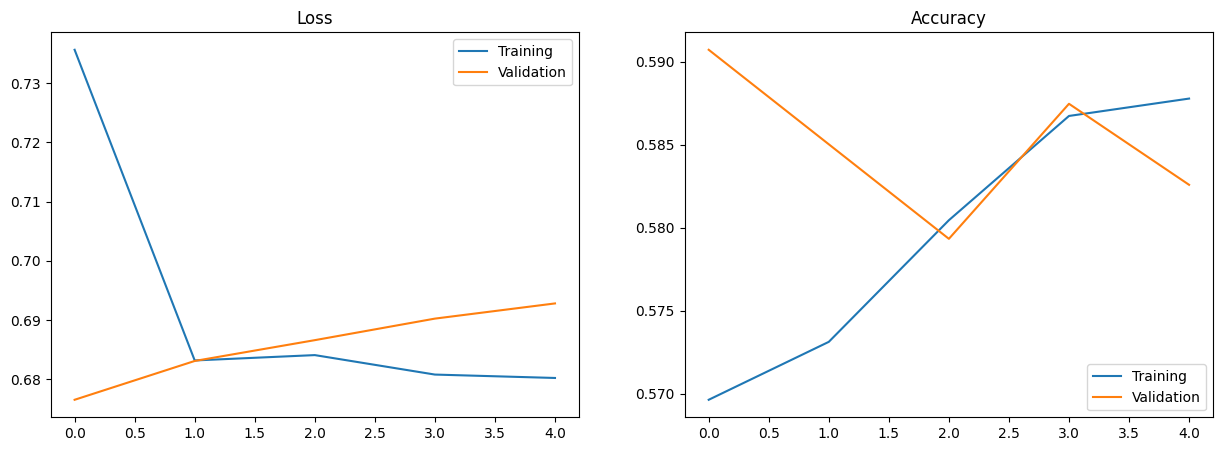

In [45]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [46]:
accuracy_pt = history['valid_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history['train_accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history['valid_accuracy'][-1]))
#print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_pt, training_time_pt/60))

Accuracy Training data: 58.8%
Accuracy Test data: 58.3%


In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score

for e in range(epochs):

    # Set mode in train mode
    model_pt.train()

    train_loss = 0.0
    train_accuracy = []

    # Loop on batches
    for X, y in tqdm(train_loader_pt):

        # Get prediction & loss
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        # Adjust the parameters of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        train_accuracy += accuracy

    train_accuracy = (sum(train_accuracy) / len(train_accuracy)).item() # Calculate the loss on the test data after each epoch
    # Set mode to evaluation (by opposition to training)
    model_pt.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []
    for X, y in test_loader_pt:

        prediction = model_pt(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()

        prediction_index = prediction.argmax(axis=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(prediction_index.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Populate history
    history["epoch"].append(e+1)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1_score"].append(f1)

    print(f'Epoch {e+1} \t\t Precision: {precision :10.3%} \t\t Recall: {recall :10.3%} \t\t F1 Score: {f1 :10.3%}')

# Measure time for training
end_time = datetime.now()
training_time_pt = (end_time - start_time).total_seconds()

  0%|          | 0/90 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model_pt.state_dict(), 'PyModel.sd')
model_reloaded = DistilBertClassification()
model_reloaded.load_state_dict(torch.load('PyModel.sd'))
model_reloaded.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1

In [ ]:
torch.save(model_pt.state_dict(), 'PyModel.sd')
model_reloaded = DistilBertClassification()
model_reloaded.load_state_dict(torch.load('PyModel.sd'))
model_reloaded.eval()

In [ ]:
framework = ['PyTorch']
accuracy = [accuracy_pt]
accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]
#training_time = [round(training_time_tf,1), round(training_time_pt,1)]
#training_time_rounded = [str(round(tt,1)) for tt in training_time]
#training_time = np.array(training_time)
#training_time_x = list((training_time/min(training_time)-1)*100)
#training_time_x = [str(round(ttx,1))+'%' for ttx in training_time_x]

dict = {'Framework' : framework,
        'Accuracy' : accuracy,
        #'Training Time [s]' : training_time_rounded,
        #'Training Time [% from best]' : training_time_x}
df = pd.DataFrame(dict)
display(df.style.hide_index())